## Task d

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge as ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import os
from mpl_toolkits import mplot3d
%matplotlib inline

from copy import deepcopy
from utils import *
from models import *

np.random.seed(0)

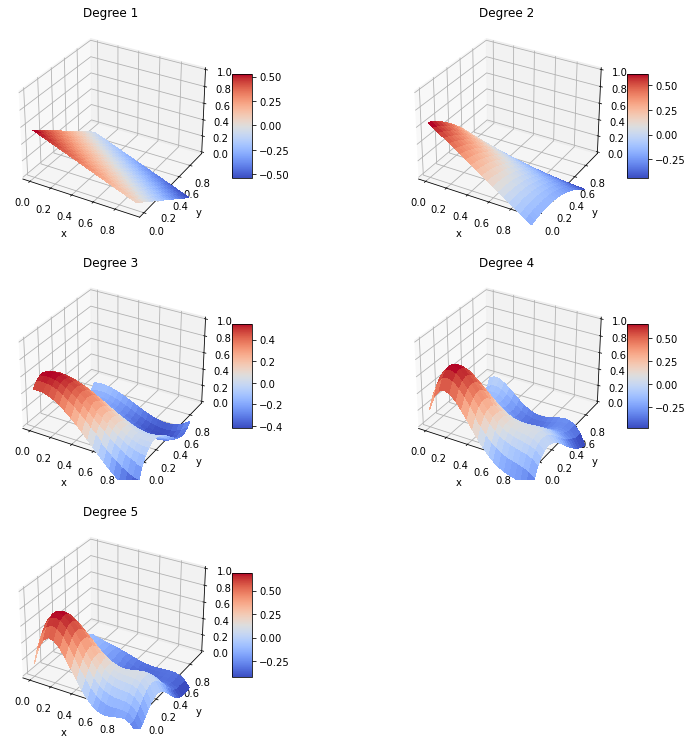

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def R2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

def MSE(y, y_hat):
    return np.mean(np.square(y - y_hat))

def z_score(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def Ridge(x, y, l):
    beta = np.linalg.pinv(x.T @ x + l*np.identity(x.shape[1]) ) @ x.T @ y
    return beta


# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)

x, y = np.meshgrid(x,y)


# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)

# Compute z
z = FrankeFunction(x, y)

# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))

# Split dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=20)

degree = [1, 2, 3, 4, 5]

#1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001,
Lambda = [ 0.00001]

predictions = []

for n_l, l in enumerate(Lambda):  
    for i,d in enumerate(degree):
        # Create the matrix of features
        poly = PolynomialFeatures(degree = d,include_bias= False )
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        features_poly = poly.fit_transform(features)
        
        # Scaling data
        scaler = StandardScaler(with_std=True)
        x_train_scaled =scaler.fit_transform(x_train_poly)
        x_test_scaled = scaler.transform(x_test_poly)
        features_scaled = scaler.transform(features_poly)
        
        # Determine optimal parameters with ridge regression
        beta = Ridge(x_train_scaled, y_train, l )
        
        Y_hat = features_scaled @ beta
        
        predictions.append(Y_hat.reshape(x.shape))
    
fig = plt.figure(figsize=(13, 13))
n = len(predictions)
rows = np.ceil(n/2).astype(int)
for i in range(n):
    ax = fig.add_subplot(rows, 2, i+1, projection='3d')
    plot_3d(x, y, predictions[i], title='Degree ' + str(i+1), show=False, figsize=(8, 8), ax=ax, fig=fig, z_limit=[0, 1])
    
save_fig(fig, name='d_pred_no-noise_no-scaling')
#plt.show()

## a.)  Bootstrap

In [3]:
def bias_variance_error(y_test, y_pred):
    error = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    return error, bias, variance

def bootstrap(X_train, y_train, x_test, y_test,
              percentage_of_train_data=1.0, degree_of_polynomial=14,
              scaling=False, add_noise=False, mean=0.0, std=0.1,
              number_of_bootstraps=100,solver=LinearRegression, **solver_args):
    e_ = np.zeros(degree_of_polynomial-1)
    b_ = np.zeros(degree_of_polynomial-1)
    v_ = np.zeros(degree_of_polynomial-1)
    X_train_actual= deepcopy(X_train)
    y_train_actual= deepcopy(y_train)
    
    indices = np.random.choice(len(y_train), int(percentage_of_train_data*len(y_train)), replace=False)
    X_train, y_train = X_train_actual[indices], y_train_actual[indices]
    # iterate over the polyniomial degree
    for d in range(1,degree_of_polynomial):
        #scale data if necessary
        if scaling == True:
            model = make_pipeline(PolynomialFeatures(degree=d ),StandardScaler(with_std= True), solver(**solver_args))
        else:
            model = make_pipeline(PolynomialFeatures(degree=d), solver(**solver_args))
        #resample and estimate the bias, varaince  and error on the test data
        y_pred = np.zeros((y_test.shape[0], number_of_bootstraps))
        for b in range(number_of_bootstraps):
            x_, y_ = resample(X_train,y_train, random_state=b)

            model_output = model.fit(x_, y_).predict(x_test).ravel()
            #print('here ', x_.shape, y_.shape, x_test.shape, model_output.shape)
            y_pred[:,b]=model_output
        error, bias, var= bias_variance_error(y_test, y_pred)

        e_[d-1]= error
        b_[d-1]= bias
        v_[d-1]= var
    return e_, b_, v_

## Bootstrap bias variance tradeoff -1
Here we examine ths bias-variance tradeoff on the test set without noise and without scaling for different values of lambda for different train-test ratios

(320, 1) (80, 1)


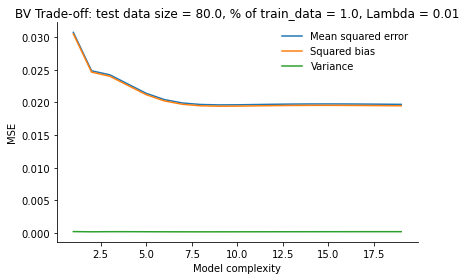

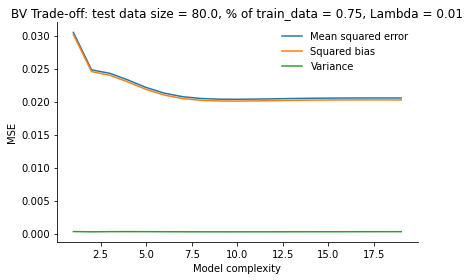

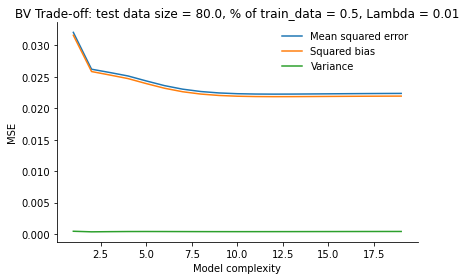

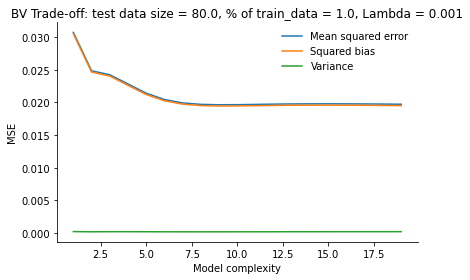

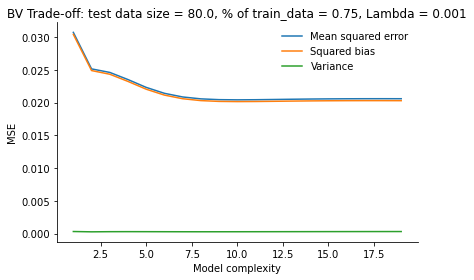

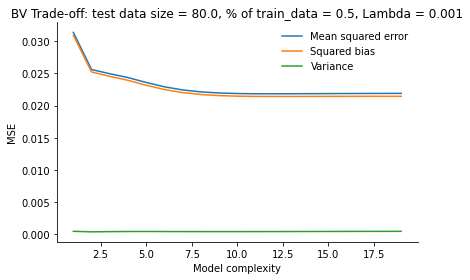

In [4]:
add_noise= False
degree_of_polynomial= 20
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 0.1, labels.shape )
else :
    labels_n = labels


# Hold out some test data that is never used in training.
X_train, x_test, y_train, y_test = train_test_split(features, labels_n, 
                                                    test_size=0.2, random_state = 2021)


print(y_train.shape, y_test.shape)

for lbd in [ 1e-2, 1e-3 ]:
    
    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': True , 'alpha': lbd}
    
    for dat in [1.0, 0.75, 0.5]:
        e,b,v = bootstrap(X_train=X_train, y_train=y_train, x_test=x_test, y_test=y_test,
                      percentage_of_train_data= dat, degree_of_polynomial=degree_of_polynomial,
                      scaling=False,
                      number_of_bootstraps=5000,solver=RidgeRegression, **solver_args)

        polynomial = np.arange(1, degree_of_polynomial)
        title = 'BV Trade-off: test data size = '+str(np.round(0.2*len(labels), 2))+', % of train_data = '+ str(dat)+', Lambda = '+str(lbd)
        plot_metric(y=[e,b,v], x= polynomial, show= True, title=title , name='d_bv_without_noise_without_scaling_'+ str(dat)+'Lambda-'+str(lbd)+'.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['Mean squared error','Squared bias','Variance'])

### Bootstrap bias variance tradeoff 

Here we examine ths bias-variance tradeoff on the test set with noise and with scaling for different values of lambda for different train-test ratios

(320, 1) (80, 1)


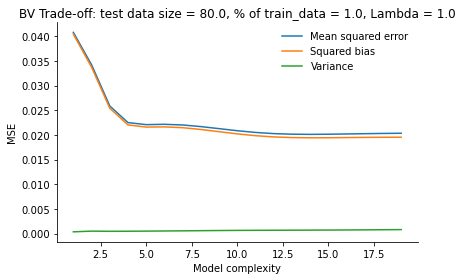

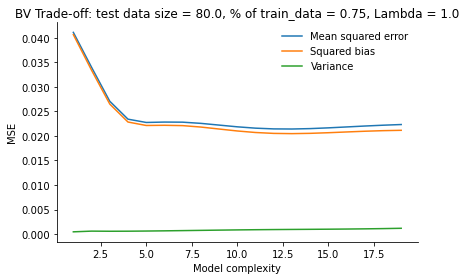

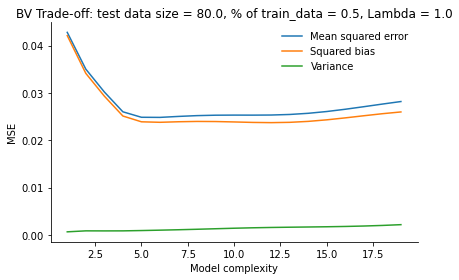

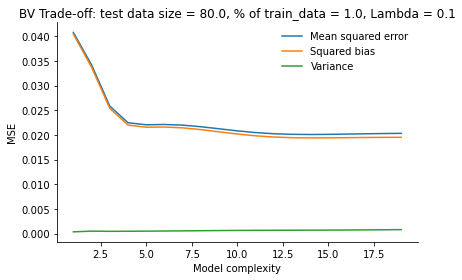

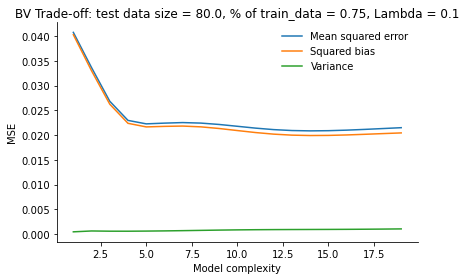

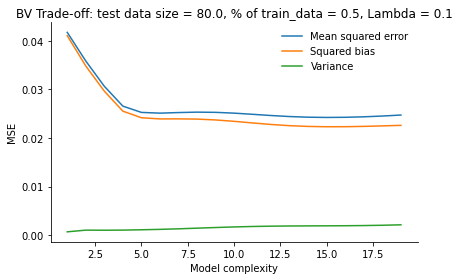

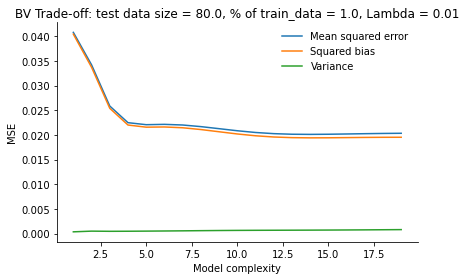

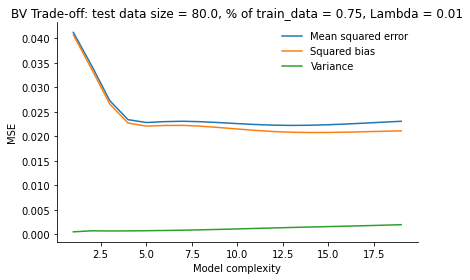

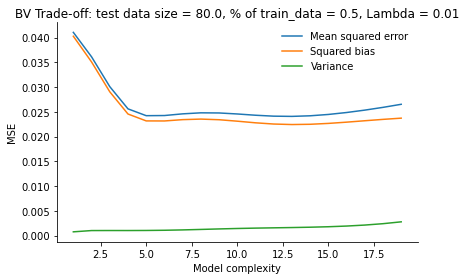

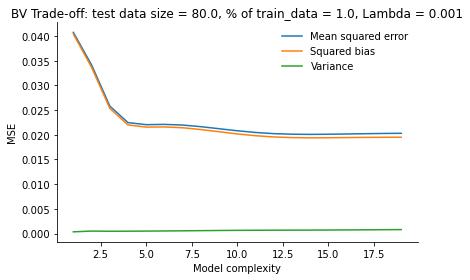

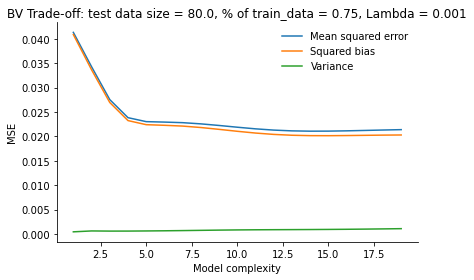

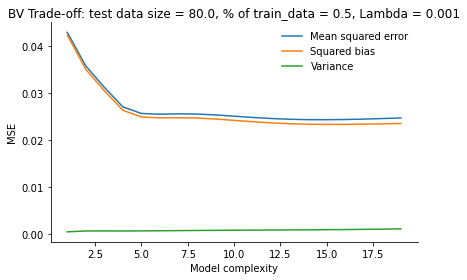

In [5]:
add_noise= True
degree_of_polynomial= 20
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 0.1, labels.shape )
else :
    labels_n = labels


# Hold out some test data that is never used in training.
X_train, x_test, y_train, y_test = train_test_split(features, labels_n, 
                                                    test_size=0.2, random_state = 2021)


print(y_train.shape, y_test.shape)

for lbd in [1e0 , 1e-1, 1e-2, 1e-3 ]:
    
    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': True , 'alpha': lbd}
    
    for dat in [1.0, 0.75, 0.5]:
        e,b,v = bootstrap(X_train=X_train, y_train=y_train, x_test=x_test, y_test=y_test,
                      percentage_of_train_data= dat, degree_of_polynomial=degree_of_polynomial,
                      scaling=True,
                      number_of_bootstraps=5000,solver=RidgeRegression, **solver_args)

        polynomial = np.arange(1, degree_of_polynomial)
        title = 'BV Trade-off: test data size = '+str(np.round(0.2*len(labels), 2))+', % of train_data = '+ str(dat)+', Lambda = '+str(lbd)
        plot_metric(y=[e,b,v], x= polynomial, show= True, title=title , name='d_bv_with_noise=0.1_with_scaling_'+ str(dat)+'Lambda-'+str(lbd)+'.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['Mean squared error','Squared bias','Variance'])

## b.) Cross-validation

In [16]:
def k_fold(X, y, k=[5],degree_of_polynomial=4, 
           scaling=False, solver=LinearRegression, **solver_args):
    
    
    test_mse=np.zeros((degree_of_polynomial-1, len(k)))
    
    for degree in range(1,degree_of_polynomial):
        #create pipeline for polynomial features and splitting over all polynomial degrees
        if scaling == True:
            data_model = make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(with_std= True))
        else:
            data_model = make_pipeline(PolynomialFeatures(degree=degree))
        
        X_d = data_model.fit_transform(X)
        y_d = y
        
        # repeat for all k 
        for f_n, fold_f in enumerate(k ):
            # split the data into k folds
            k_fold= KFold(n_splits=fold_f)
            fold_f_mse=0.0
            #train on (fold_f-1) folds and test on the left out fold
            if solver == LinearRegression or solver == RidgeRegression or solver== Lasso:
                for nk, (train_index, test_index) in enumerate(k_fold.split(X_d)):
                    x_train, x_test = X_d[train_index], X_d[test_index]
                    y_train, y_test = y_d[train_index], y_d[test_index]
                    if solver in [LinearRegression, RidgeRegression]:
                        model = solver(**solver_args, dimension=x_train.shape)                    
                        # evaluate mse on left out fold
                        model.fit(x_train, y_train)
                        y_hat_test=model.predict(x_test)
                    else:
                        model = solver(**solver_args)
                        y_hat_test= model.fit(x_train, y_train).predict(x_test)
                    
                    mse_local = MSE(y_hat_test, y_test)
                    fold_f_mse+=mse_local

                fold_f_mse/=fold_f
            
            else:
                model= solver(**solver_args)
                fold_f_mse=-cross_val_score(model, X_d, y_d, scoring='neg_mean_squared_error', cv=fold_f)
                fold_f_mse=np.mean(fold_f_mse)
                
            test_mse[degree-1, f_n]=fold_f_mse
                      
        
    return test_mse      

### Without noise and without scaling

(9, 6)
[[0.04369364 0.03743394 0.03731793 0.03394265 0.03289658 0.03326361]
 [0.0461909  0.03855102 0.03586251 0.03128351 0.03031456 0.02963595]
 [0.06090684 0.04651272 0.04134463 0.03430353 0.03235785 0.03131516]
 [0.0690238  0.04849653 0.04183539 0.03350846 0.03071903 0.02973459]
 [0.07092365 0.04653928 0.03925783 0.0307593  0.02764873 0.02684458]
 [0.06959382 0.04318711 0.0358256  0.02773039 0.02476404 0.0241339 ]
 [0.06706283 0.03976305 0.03265707 0.02517456 0.02263568 0.02214843]
 [0.06436578 0.03678832 0.03014318 0.02330062 0.02130607 0.02093053]
 [0.06194602 0.03439743 0.02832374 0.02207495 0.02063248 0.02033903]]


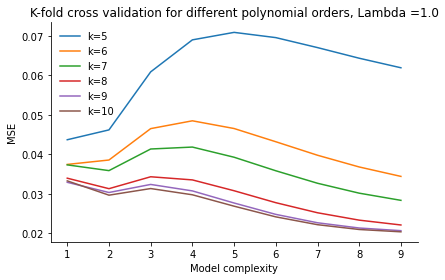

(9, 6)
[[0.04552459 0.03858618 0.03827056 0.03458821 0.03344965 0.03372889]
 [0.08770876 0.05832142 0.05001286 0.03907116 0.03690441 0.03480721]
 [0.07814509 0.04533901 0.03781894 0.02839919 0.02521603 0.02356019]
 [0.05559862 0.02939548 0.02514683 0.01924276 0.01711494 0.01595678]
 [0.03942984 0.02138481 0.02029602 0.01627936 0.01545847 0.01448511]
 [0.032474   0.02038968 0.02121705 0.01737281 0.01705176 0.01594361]
 [0.03290874 0.0239847  0.02504682 0.02030318 0.01969278 0.01821712]
 [0.03816692 0.03019013 0.02990312 0.02365816 0.02233651 0.0203209 ]
 [0.04601174 0.03757718 0.0347331  0.02668078 0.02456479 0.02188223]]


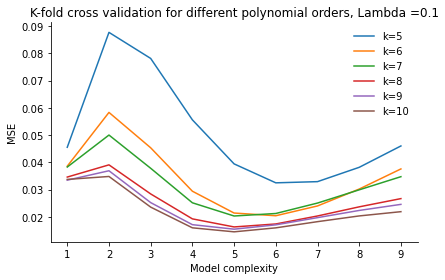

(9, 6)
[[0.04574212 0.03872461 0.038384   0.03466708 0.03351737 0.03378615]
 [0.1089631  0.06711174 0.05571216 0.04220014 0.03940098 0.03662402]
 [0.03434959 0.01798116 0.01603499 0.01352871 0.01233611 0.01092457]
 [0.02703138 0.01725406 0.01667467 0.014175   0.0139059  0.01232568]
 [0.0437443  0.02642812 0.0216279  0.01735505 0.0165491  0.0144168 ]
 [0.06882211 0.03563447 0.02446364 0.01852103 0.01710846 0.01465839]
 [0.09287819 0.04075944 0.02407067 0.01727812 0.01587174 0.01336569]
 [0.11063549 0.04101694 0.02124039 0.01474967 0.01377889 0.011384  ]
 [0.12067549 0.0375238  0.01740393 0.01219775 0.01164119 0.00947887]]


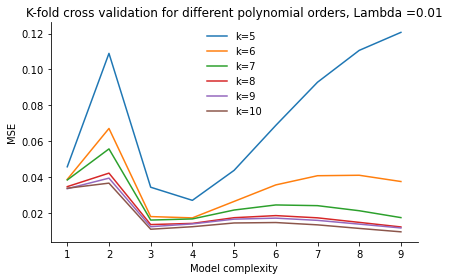

(9, 6)
[[0.04576425 0.0387387  0.03839554 0.03467512 0.03352428 0.03379199]
 [0.11194519 0.0682876  0.056444   0.04259691 0.03971216 0.03684437]
 [0.01900054 0.01297172 0.01262553 0.01200458 0.01186772 0.01075165]
 [0.04249271 0.02427798 0.01611395 0.01459366 0.01401416 0.01230002]
 [0.06798908 0.02836204 0.01502065 0.01305109 0.01231273 0.01112162]
 [0.07096858 0.02197332 0.01070379 0.0095051  0.00902022 0.00802421]
 [0.05493321 0.01377248 0.00785461 0.00770012 0.00723091 0.00622412]
 [0.03274611 0.01087349 0.00982921 0.00854545 0.00776436 0.00683728]
 [0.0177066  0.01664982 0.0176116  0.01138726 0.01004255 0.00928657]]


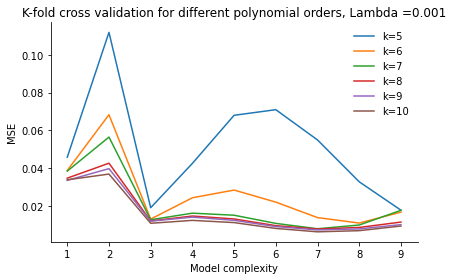

In [17]:
degree_of_polynomial=10
k=[5, 6, 7, 8, 9, 10]

add_noise= False

if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 0.1, labels.shape )
else :
    labels_n = labels
    
    
for lbd in [1e0 , 1e-1, 1e-2, 1e-3 ]:
    
    #define the input argumets for the solver 
    solver_args ={ 'alpha' : lbd, 'fit_intercept': True}


    t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
               scaling= False , solver=ridge , **solver_args)
    print(t.shape)
    print(t)

    polynomial=np.arange(1, degree_of_polynomial)
    title = 'K-fold cross validation for different polynomial orders, Lambda =' + str(lbd)
    plot_metric(y= t.T, x= polynomial, show= True, title=title , name='d_kf_without_noise_without_scaling_.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])


### With noise  and with scaling

(9, 6)
[[0.05865649 0.0510876  0.0516254  0.0475996  0.04646845 0.04671844]
 [0.10173556 0.07037278 0.0653075  0.05361265 0.05087993 0.04842841]
 [0.08214408 0.05178907 0.04892346 0.04077773 0.03648912 0.0339002 ]
 [0.05318128 0.03450773 0.03476301 0.03065262 0.02824874 0.02619005]
 [0.03947334 0.03070958 0.03148355 0.02821995 0.02764707 0.02605272]
 [0.0468336  0.03973056 0.0354859  0.03064359 0.03054676 0.02911516]
 [0.07349174 0.05743999 0.04245277 0.03412494 0.03381021 0.03237493]
 [0.11520108 0.07892838 0.04914289 0.03615102 0.03580164 0.03430939]
 [0.16645814 0.09925612 0.05341683 0.0360122  0.03607284 0.03447493]]


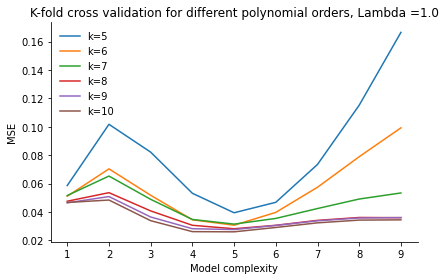

(9, 6)
[[0.05884237 0.05120323 0.05172842 0.04767211 0.04653088 0.04677083]
 [0.120161   0.07795276 0.07071248 0.05665527 0.05328559 0.05018575]
 [0.03860545 0.02787816 0.02748904 0.02547263 0.02419299 0.02212646]
 [0.04209444 0.03369334 0.0286914  0.0262451  0.02613652 0.0240945 ]
 [0.08124965 0.05124784 0.03475584 0.02947618 0.02908956 0.02650279]
 [0.13235228 0.06334672 0.03683809 0.02910351 0.02874282 0.02564805]
 [0.1714813  0.06210224 0.03375854 0.02739488 0.02690982 0.02249286]
 [0.18673384 0.04994817 0.03028912 0.02937548 0.02677575 0.01936501]
 [0.17773629 0.03463639 0.03286746 0.0390679  0.03075109 0.01801742]]


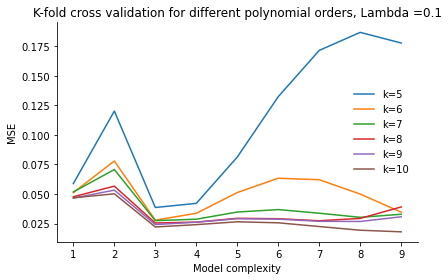

(9, 6)
[[0.05886123 0.05121497 0.05173887 0.04767947 0.04653722 0.04677616]
 [0.12260598 0.0789147  0.07137452 0.05702169 0.05357149 0.05039017]
 [0.03000321 0.02631692 0.02424014 0.02307523 0.02299166 0.02172888]
 [0.07658949 0.04759786 0.03009299 0.02753825 0.02690326 0.02405041]
 [0.1088528  0.04653634 0.02755858 0.02455107 0.02391823 0.02030016]
 [0.09431577 0.03205506 0.02326464 0.02349071 0.02200086 0.01611129]
 [0.05869702 0.02348284 0.02721404 0.03057211 0.02443992 0.01550772]
 [0.03204248 0.03285746 0.04749197 0.04897906 0.03189089 0.01808427]
 [0.0462169  0.0680208  0.08698421 0.07902928 0.0431875  0.02151417]]


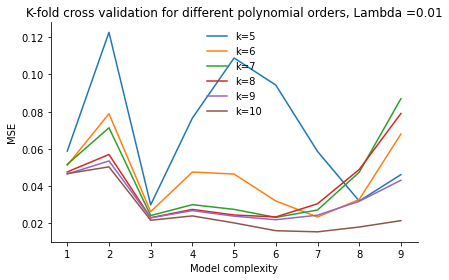

(9, 6)
[[0.05886312 0.05121614 0.05173991 0.04768021 0.04653786 0.04677669]
 [0.12285845 0.07901348 0.0714422  0.05705907 0.05360062 0.05041094]
 [0.03021069 0.02700507 0.02424185 0.02305823 0.02305409 0.02189295]
 [0.10743703 0.05382823 0.03162122 0.02851836 0.02742743 0.0255033 ]
 [0.06535978 0.02783921 0.02109564 0.02015026 0.01920643 0.01520287]
 [0.0336475  0.02611865 0.02839973 0.02985879 0.02284583 0.01606988]
 [0.06515821 0.05147555 0.05247631 0.05292406 0.03006019 0.0187562 ]
 [0.19237204 0.09545271 0.08677089 0.08494676 0.03742447 0.01917802]
 [0.39891676 0.14018842 0.12958387 0.12372043 0.045304   0.01634071]]


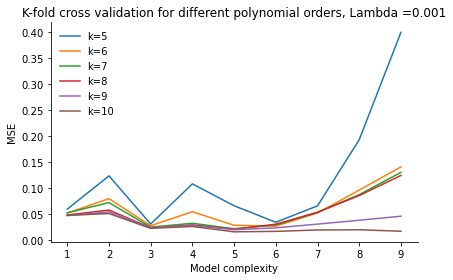

In [18]:
degree_of_polynomial=10
k=[5, 6, 7, 8, 9, 10]

add_noise= True

if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 0.1, labels.shape )
else :
    labels_n = labels
    
    
for lbd in [1e0 , 1e-1, 1e-2, 1e-3 ]:
    
    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': True, 'alpha' : lbd}


    t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
               scaling= True , solver=ridge , **solver_args)
    print(t.shape)
    print(t)

    polynomial=np.arange(1, degree_of_polynomial)
    title = 'K-fold cross validation for different polynomial orders, Lambda =' + str(lbd)
    plot_metric(y= t.T, x= polynomial, show= True, title=title , name='d_kf_with_noise=0.1_with_scaling_.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])
